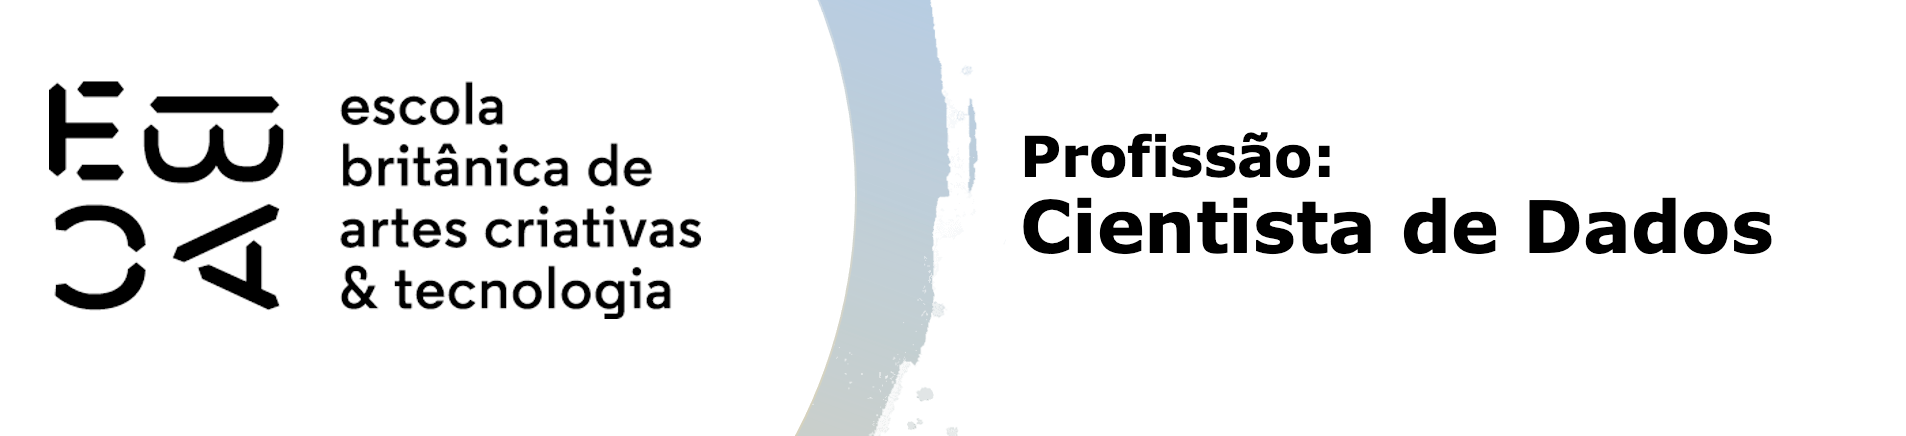

____________

### Aluno: Victor Resende

____________

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

## Instalações Necessárias:

## Carregando as Bibliotecas Necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import warnings


In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Garantindo que a variável data_ref esteja no formato datetime:
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenando o dataframe pela data_ref para facilitar a amostragem:
df = df.sort_values(by='data_ref').reset_index(drop=True)

# Identificando os três últimos meses como validação OOT:
ultimo_mes = df['data_ref'].max()
tres_meses_oot = ultimo_mes - pd.DateOffset(months=3)

# Dividindo os dados:
train_val_df = df[df['data_ref'] < tres_meses_oot]
oot_df = df[df['data_ref'] >= tres_meses_oot]

# Verificando os tamanhos das bases:
print("\nTamanhos das bases:")
print(f"Treino/Validação: {train_val_df.shape[0]} registros")
print(f"OOT: {oot_df.shape[0]} registros")

# Visualizando as safras OOT:
print("\nSafras de validação OOT:")
print(oot_df['data_ref'].value_counts().sort_index())



Tamanhos das bases:
Treino/Validação: 550000 registros
OOT: 200000 registros

Safras de validação OOT:
data_ref
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Ordenando o dataframe pela data_ref para facilitar a amostragem:
df = df.sort_values(by='data_ref').reset_index(drop=True)

# Identificando os três últimos meses como validação OOT:
ultimo_mes = df['data_ref'].max()
tres_meses_oot = ultimo_mes - pd.DateOffset(months=3)

# Dividindo os dados:
train_val_df = df[df['data_ref'] < tres_meses_oot]
oot_df = df[df['data_ref'] >= tres_meses_oot]

# Verificando os tamanhos das bases:
print("\nTamanhos das bases:")
print(f"Treino/Validação: {train_val_df.shape[0]} registros")
print(f"OOT: {oot_df.shape[0]} registros")

# Visualizando as safras OOT:
print("\nSafras de validação OOT:")
print(oot_df['data_ref'].value_counts().sort_index())

# Descritiva básica univariada:
print("\nDescritiva básica univariada da base completa:")
print(f"Número total de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")

# Contagem de registros por mês:
print("\nNúmero de linhas por mês em data_ref:")
print(df['data_ref'].value_counts().sort_index())

# Separando variáveis qualitativas e quantitativas:
qualitativas = df.select_dtypes(include=['object', 'category']).columns.tolist()
quantitativas = df.select_dtypes(include=['number']).columns.tolist()

# Descrição das variáveis qualitativas:
print("\nDescritiva das variáveis qualitativas:")
for col in qualitativas:
    print(f"\nVariável: {col}")
    print(df[col].value_counts())

# Descrição das variáveis quantitativas:
print("\nDescritiva das variáveis quantitativas:")
print(df[quantitativas].describe())



Tamanhos das bases:
Treino/Validação: 550000 registros
OOT: 200000 registros

Safras de validação OOT:
data_ref
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Descritiva básica univariada da base completa:
Número total de linhas: 750000
Número de colunas: 15

Número de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Descritiva das variáveis qualitativas:

Variável: sexo
sexo
F    504580
M    245420
Name: count, dtype: int64

Variável: posse_de_veiculo
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Variável: posse_de_imovel
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Variáv

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Calculando IV e gerando gráficos de perfil para cada variável:


C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

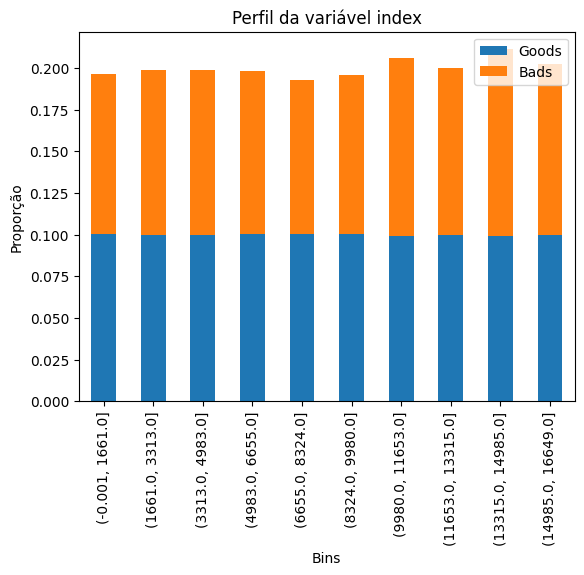

C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

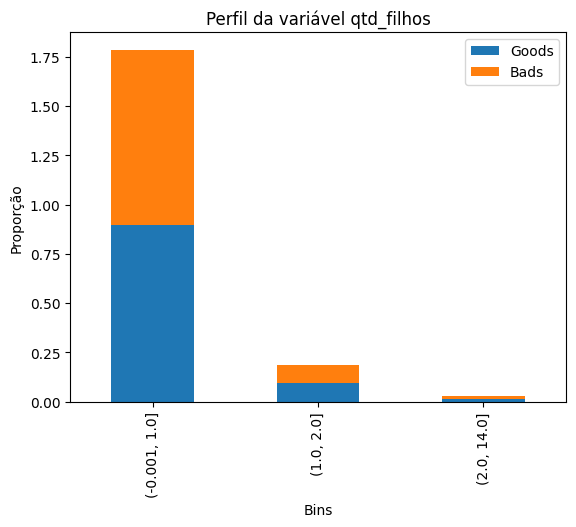

C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

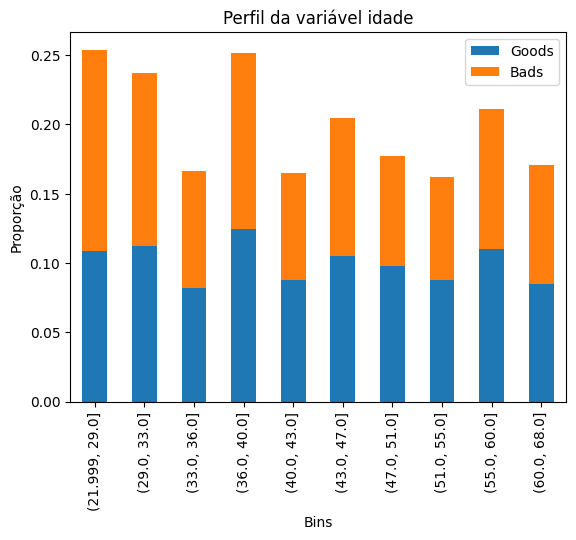

C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

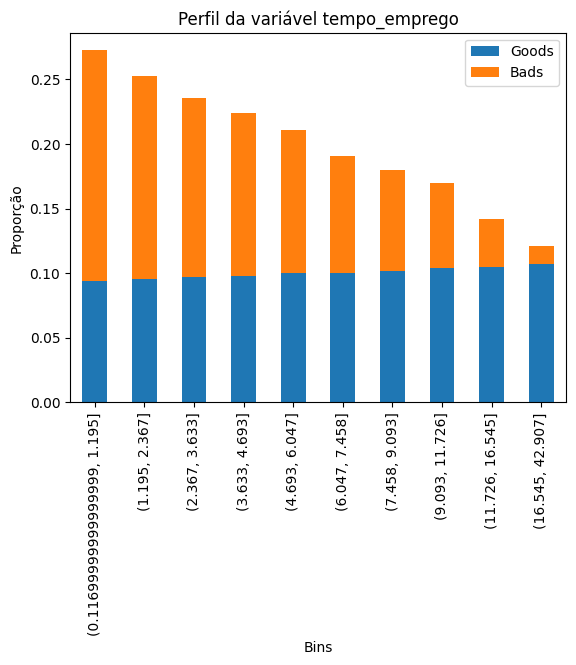

C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

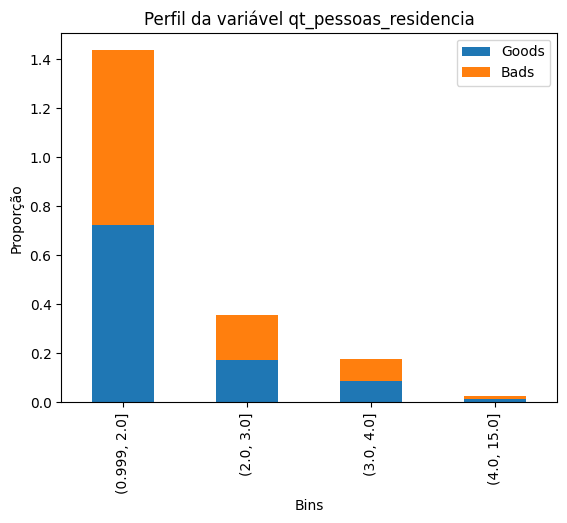

C:\Users\User\AppData\Local\Temp\ipykernel_3296\996443099.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})


<Figure size 1000x600 with 0 Axes>

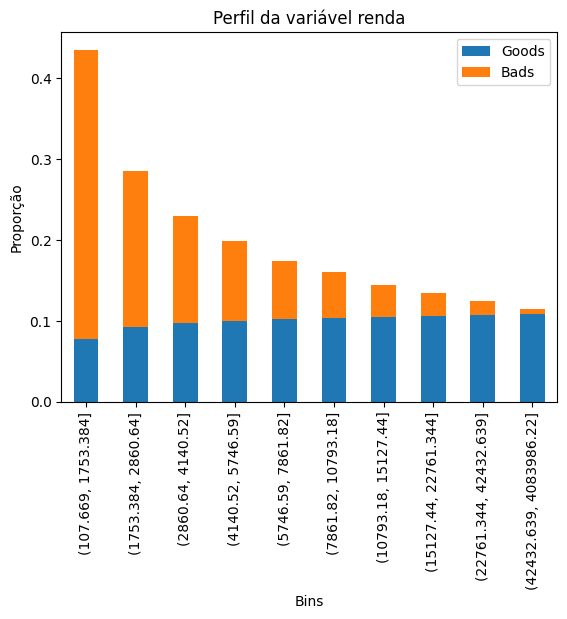

<Figure size 1000x600 with 0 Axes>

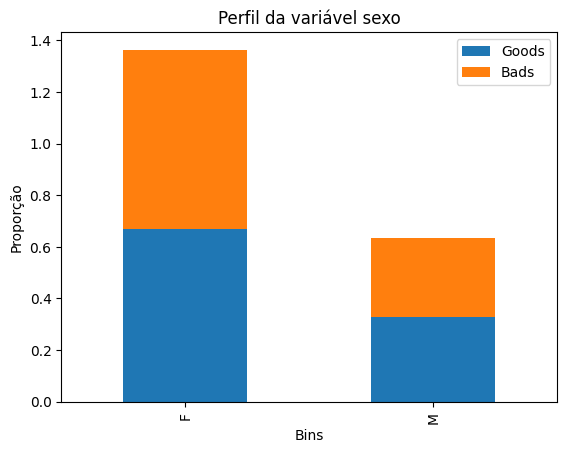

<Figure size 1000x600 with 0 Axes>

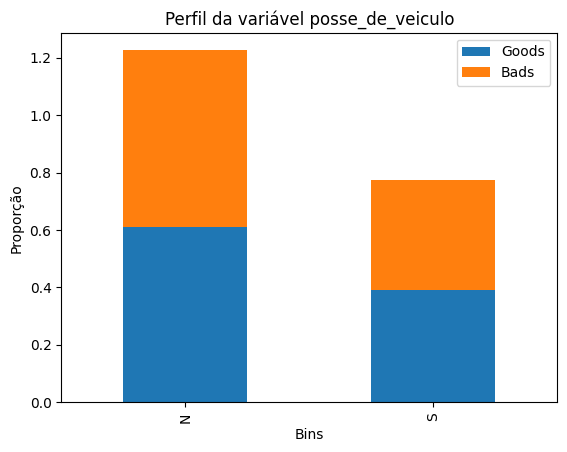

<Figure size 1000x600 with 0 Axes>

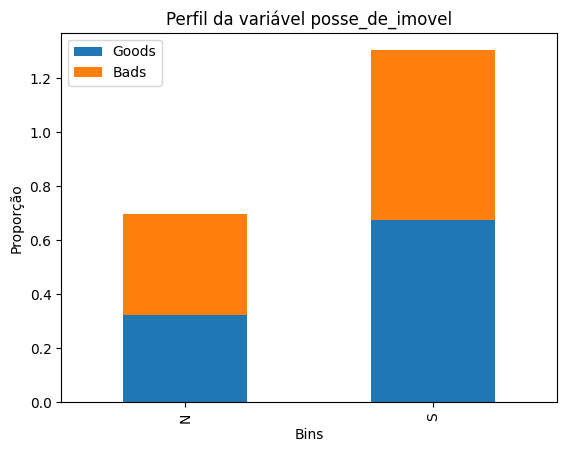

<Figure size 1000x600 with 0 Axes>

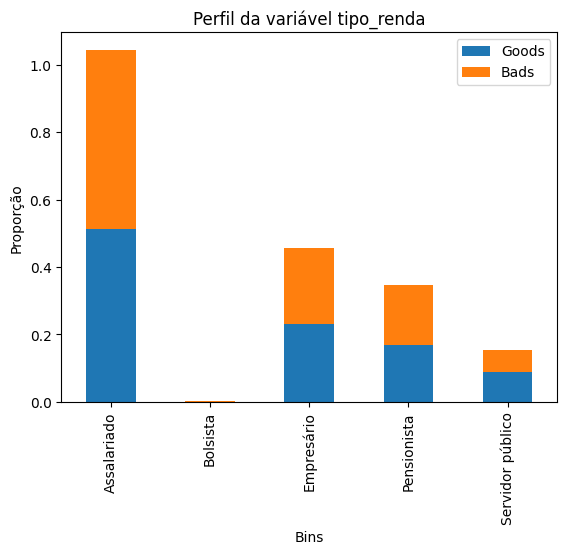

<Figure size 1000x600 with 0 Axes>

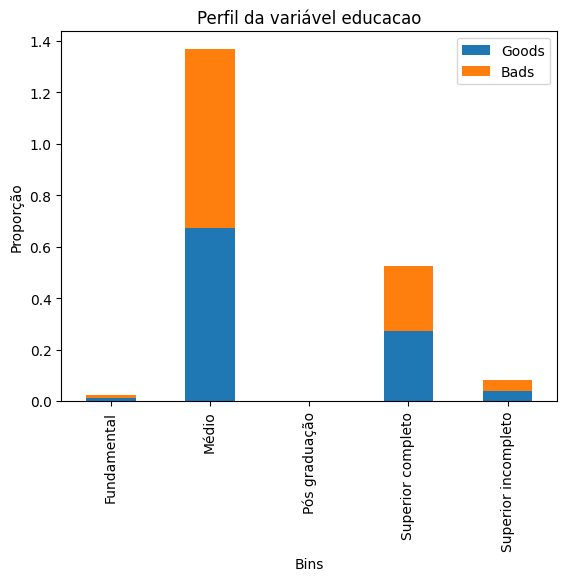

<Figure size 1000x600 with 0 Axes>

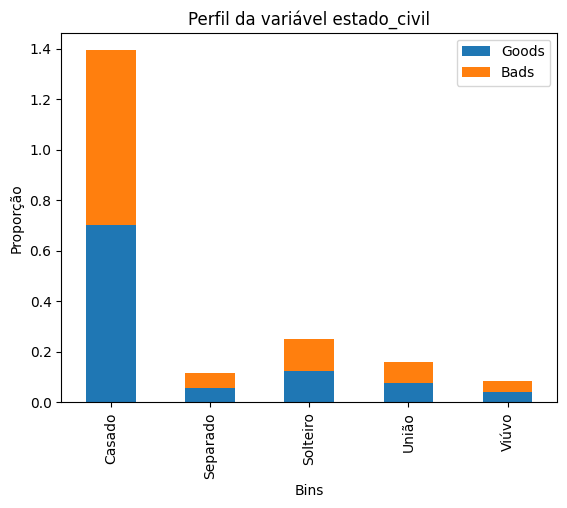

<Figure size 1000x600 with 0 Axes>

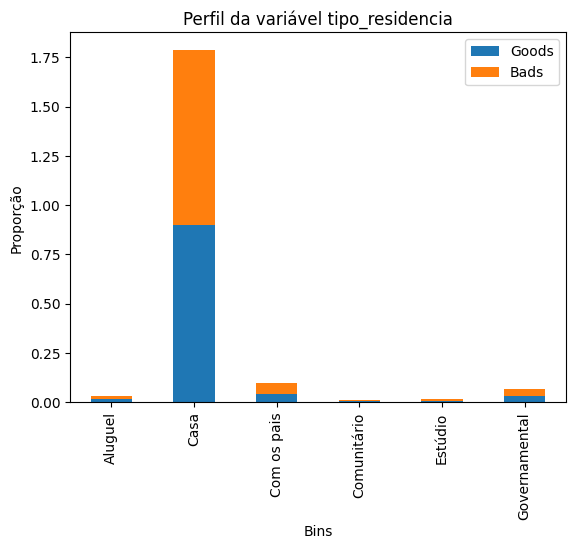


Resultados de IV:
Variável: renda, IV: 1.1634
Variável: tempo_emprego, IV: 0.3868
Variável: idade, IV: 0.0208
Variável: posse_de_imovel, IV: 0.0097
Variável: tipo_renda, IV: 0.0094
Variável: index, IV: 0.0036
Variável: educacao, IV: 0.0035
Variável: tipo_residencia, IV: 0.0030
Variável: sexo, IV: 0.0022
Variável: qt_pessoas_residencia, IV: 0.0014
Variável: estado_civil, IV: 0.0011
Variável: posse_de_veiculo, IV: 0.0001
Variável: qtd_filhos, IV: 0.0001


In [5]:
# Função para calcular o Information Value (IV):
def calculate_iv(df, feature, target, bins=10):
    """
    Calcula o Information Value (IV) para uma variável.
    :param df: DataFrame contendo os dados
    :param feature: Nome da variável explicativa
    :param target: Nome da variável resposta
    :param bins: Número de bins para variáveis contínuas
    :return: IV e WOE dataframe
    """
    # Tratando variáveis categóricas e numéricas:
    if df[feature].dtype in ['int64', 'float64']:
        df['temp_bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    else:
        df['temp_bin'] = df[feature]

    # Calculando os totais de bons e maus por bin:
    iv_df = df.groupby('temp_bin').agg({target: ['sum', 'count']})
    iv_df.columns = ['bads', 'total']
    iv_df['goods'] = iv_df['total'] - iv_df['bads']

    # Calculando proporções:
    iv_df['prop_bads'] = iv_df['bads'] / iv_df['bads'].sum()
    iv_df['prop_goods'] = iv_df['goods'] / iv_df['goods'].sum()

    # Calculando Weight of Evidence (WOE) e IV:
    iv_df['woe'] = np.log(iv_df['prop_goods'] / iv_df['prop_bads']).replace([np.inf, -np.inf], 0)
    iv_df['iv'] = (iv_df['prop_goods'] - iv_df['prop_bads']) * iv_df['woe']

    # Somando IV total:
    iv = iv_df['iv'].sum()
    return iv, iv_df

# Calculando IV para cada variável e gerando os gráficos:
iv_results = {}

print("\nCalculando IV e gerando gráficos de perfil para cada variável:")
for col in quantitativas + qualitativas:
    if col == 'mau':
        continue
    iv, iv_df = calculate_iv(df, col, 'mau')
    iv_results[col] = iv

    # Plotando o gráfico de perfil:
    plt.figure(figsize=(10, 6))
    iv_df[['prop_goods', 'prop_bads']].plot(kind='bar', stacked=True)
    plt.title(f'Perfil da variável {col}')
    plt.xlabel('Bins')
    plt.ylabel('Proporção')
    plt.legend(['Goods', 'Bads'])
    plt.show()

# Ordenando os resultados por IV:
iv_sorted = sorted(iv_results.items(), key=lambda x: x[1], reverse=True)
print("\nResultados de IV:")
for var, iv in iv_sorted:
    print(f"Variável: {var}, IV: {iv:.4f}")


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratando valores missing, outiliers e zeros estruturais

In [6]:
# Análise inicial:
df.info()  # Para verificar tipos de dados e valores ausentes
df.describe()  # Estatísticas descritivas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,2015-08-01 06:24:00,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,2015-04-01 00:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,2015-08-01 00:00:00,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,2015-12-01 00:00:00,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,2016-03-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04


In [7]:
# Tratando valores missing:
df['renda'] = df['renda'].fillna(df['renda'].median())
df['qtd_filhos'] = df['qtd_filhos'].fillna(df['qtd_filhos'].median())
df['idade'] = df['idade'].fillna(df['idade'].median())
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].fillna(df['qt_pessoas_residencia'].median())

df['sexo'] = df['sexo'].fillna(df['sexo'].mode()[0])
df['posse_de_veiculo'] = df['posse_de_veiculo'].fillna(df['posse_de_veiculo'].mode()[0])
df['posse_de_imovel'] = df['posse_de_imovel'].fillna(df['posse_de_imovel'].mode()[0])
df['tipo_renda'] = df['tipo_renda'].fillna(df['tipo_renda'].mode()[0])
df['educacao'] = df['educacao'].fillna(df['educacao'].mode()[0])
df['estado_civil'] = df['estado_civil'].fillna(df['estado_civil'].mode()[0])
df['tipo_residencia'] = df['tipo_residencia'].fillna(df['tipo_residencia'].mode()[0])


In [8]:
# Tratando outliers com IQR para a coluna 'renda':
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo limites:
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Removendo outliers:
df = df[(df['renda'] >= limite_inferior) & (df['renda'] <= limite_superior)]


In [9]:
# Substituindo 'zeros estruturais' por NaN:
df['tempo_emprego'] = df['tempo_emprego'].replace(0, np.nan)

# Tratando novamente valores missing para 'tempo_emprego':
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())


### Agrupando categorias

In [10]:
# Agrupando categorias de estado civil:
df['estado_civil'] = df['estado_civil'].replace({
    'Solteiro(a)': 'Solteiro',
    'Casado(a)': 'Casado',
    'Divorciado(a)': 'Divorciado',
    'Viúvo(a)': 'Viúvo'
})

### Equação preditiva para 'mau'

In [11]:
# Selecionando variáveis preditoras:
X = df[['renda', 'idade', 'qtd_filhos', 'tempo_emprego', 'educacao', 'estado_civil', 'tipo_residencia']]
X = pd.get_dummies(X)  # Criando variáveis dummy para variáveis categóricas

# Variável alvo:
y = df['mau']

# Dividindo em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo de regressão logística:
model = LogisticRegression()
model.fit(X_train, y_train)

# Previsões e avaliação:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.91      1.00      0.95    122549
        True       0.00      0.00      0.00     11637

    accuracy                           0.91    134186
   macro avg       0.46      0.50      0.48    134186
weighted avg       0.83      0.91      0.87    134186



C:\Users\User\anaconda3\envs\pycaret-env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision 

### Verificando possíveis categorais não significantes

In [12]:
# Garantindo que as variáveis categóricas sejam convertidas em variáveis dummy:
X = df[['renda', 'idade', 'qtd_filhos', 'tempo_emprego', 'educacao', 'estado_civil', 'tipo_residencia']]
X = pd.get_dummies(X, drop_first=True)  # Criando variáveis dummy para variáveis categóricas

# Convertendo colunas booleanas para inteiros (0 ou 1):
X = X.astype(int)

# Garantindo que as variáveis numéricas não tenham valores não numéricos (e.g., strings):
X = X.apply(pd.to_numeric, errors='coerce')  # Converte valores não numéricos em NaN
X = X.fillna(X.median())  # Preenche NaNs com a mediana

# Adicionando uma constante (intercepto) ao modelo:
X = sm.add_constant(X)

# Variável alvo
y = df['mau']

# Garantindo que a variável alvo seja numérica (0 ou 1):
y = pd.to_numeric(y, errors='coerce')  # Converte a variável para numérica, substituindo erros por NaN
y = y.fillna(y.mode()[0])  # Preenche NaNs com o valor modal (mais frequente)
y = y.astype(int)  # Assegura que a variável alvo seja inteira (0 ou 1)

# Verificando os tipos de dados para garantir que estão corretos:
print(X.dtypes)
print(y.dtypes)

# Ajustando o modelo de regressão logística:
model = sm.Logit(y, X)
result = model.fit()

# Exibindo o resumo do modelo, incluindo p-values:
print(result.summary())


const                            float64
renda                              int32
idade                              int32
qtd_filhos                         int32
tempo_emprego                      int32
educacao_Médio                     int32
educacao_Pós graduação             int32
educacao_Superior completo         int32
educacao_Superior incompleto       int32
estado_civil_Separado              int32
estado_civil_Solteiro              int32
estado_civil_União                 int32
estado_civil_Viúvo                 int32
tipo_residencia_Casa               int32
tipo_residencia_Com os pais        int32
tipo_residencia_Comunitário        int32
tipo_residencia_Estúdio            int32
tipo_residencia_Governamental      int32
dtype: object
int32
Optimization terminated successfully.
         Current function value: 0.266018
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:    

In [13]:
# Removendo as variáveis não significantes:
X_reduced = X.drop(columns=['idade', 'qtd_filhos', 'educacao_Médio', 'educacao_Pós graduação', 
                            'educacao_Superior incompleto', 'estado_civil_Solteiro', 
                            'estado_civil_Viúvo', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 
                            'tipo_residencia_Estúdio', 'tipo_residencia_Governamental'])

# Ajustando o modelo de regressão logística com as variáveis significantes:
model_reduced = sm.Logit(y, X_reduced)
result_reduced = model_reduced.fit()

# Exibindo o resumo do modelo ajustado:
result_reduced.summary()


Optimization terminated successfully.
         Current function value: 0.266033
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               670928
Model:                          Logit   Df Residuals:                   670921
Method:                           MLE   Df Model:                            6
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.09827
Time:                        16:43:12   Log-Likelihood:            -1.7849e+05
converged:                       True   LL-Null:                   -1.9794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.1900      0.009   -132.140      0.000      -1.208      -1.172
renda                          -0.0002   1.23e-06   -134.067      0.000      -0.000      -0.000
tempo_emprego                  -0.0215      0.001    -15.497      0.000      -0.024      -0.019
educacao_Superior completo     -0.0388      0.010     -3.765      0.000      -0.059      -0.019
estado_civil_Separado           0.0451      0.019      2.381      0.017       0.008       0.082
estado_civil_União              0.0373      0.016      2.289      0.022       0.005       0.069
tipo_residencia_Comunitário    -0.0988      0.065     -1.530      0.126      -0.225       0.028
===============================================================================================
"""

___________

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [14]:
# Definindo as variáveis significativas:
variaveis_significativas = ['renda', 'tempo_emprego', 'educacao_Superior completo', 
                            'estado_civil_Separado', 'estado_civil_União', 
                            'tipo_residencia_Comunitário']

# Dividindo os dados em treino e validação (base de desenvolvimento):
X_train, X_val, y_train, y_val = train_test_split(X[variaveis_significativas], y, test_size=0.2, random_state=42)

# Dividindo 80% dos dados para treino e validação, e 20% para o out-of-time:
X_oos, _, y_oos, _ = train_test_split(X[variaveis_significativas], y, test_size=0.8, random_state=42)

# Exibindo as formas das variáveis:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de X_oos: {X_oos.shape}")


Forma de X_train: (536742, 6)
Forma de X_val: (134186, 6)
Forma de X_oos: (134185, 6)


In [15]:
# Função para calcular o índice KS:
def ks_statistic(y_true, y_prob):
    data = np.vstack([y_prob, y_true]).T
    data = data[data[:, 0].argsort()]  # Ordena pelo valor de probabilidade
    cdf_pos = np.cumsum(data[:, 1] == 1) / np.sum(data[:, 1] == 1)  # Positivos
    cdf_neg = np.cumsum(data[:, 1] == 0) / np.sum(data[:, 1] == 0)  # Negativos
    ks = np.max(np.abs(cdf_pos - cdf_neg))  # KS é a maior diferença entre as distribuições acumuladas
    return ks

# Função para calcular o índice de Gini:
def gini_index(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)  # AUC é a área sob a curva ROC
    return 2 * auc - 1  # Gini = 2 * AUC - 1

# Ajustando o modelo de regressão logística com as variáveis significativas:
from sklearn.linear_model import LogisticRegression

# Ajuste do modelo:
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtendo as probabilidades previstas:
y_prob_val = model.predict_proba(X_val)[:, 1]  # Probabilidade para a classe positiva
y_prob_oos = model.predict_proba(X_oos)[:, 1]

# Acurácia:
acc_val = accuracy_score(y_val, model.predict(X_val))
acc_oos = accuracy_score(y_oos, model.predict(X_oos))

# KS:
ks_val = ks_statistic(y_val, y_prob_val)
ks_oos = ks_statistic(y_oos, y_prob_oos)

# Gini:
gini_val = gini_index(y_val, y_prob_val)
gini_oos = gini_index(y_oos, y_prob_oos)

# Exibindo os resultados
print(f"Acurácia na base de validação: {acc_val:.4f}")
print(f"Acurácia na base out-of-time: {acc_oos:.4f}")
print(f"KS na base de validação: {ks_val:.4f}")
print(f"KS na base out-of-time: {ks_oos:.4f}")
print(f"Gini na base de validação: {gini_val:.4f}")
print(f"Gini na base out-of-time: {gini_oos:.4f}")


C:\Users\User\anaconda3\envs\pycaret-env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia na base de validação: 0.9133
Acurácia na base out-of-time: 0.9130
KS na base de validação: 0.3892
KS na base out-of-time: 0.3944
Gini na base de validação: 0.5203
Gini na base out-of-time: 0.5234


C:\Users\User\AppData\Local\Temp\ipykernel_3296\3245821614.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Base", y=metric, ax=axes[i], palette="muted")
C:\Users\User\AppData\Local\Temp\ipykernel_3296\3245821614.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Base", y=metric, ax=axes[i], palette="muted")
C:\Users\User\AppData\Local\Temp\ipykernel_3296\3245821614.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Base", y=metric, ax=axes[i], palette="muted")


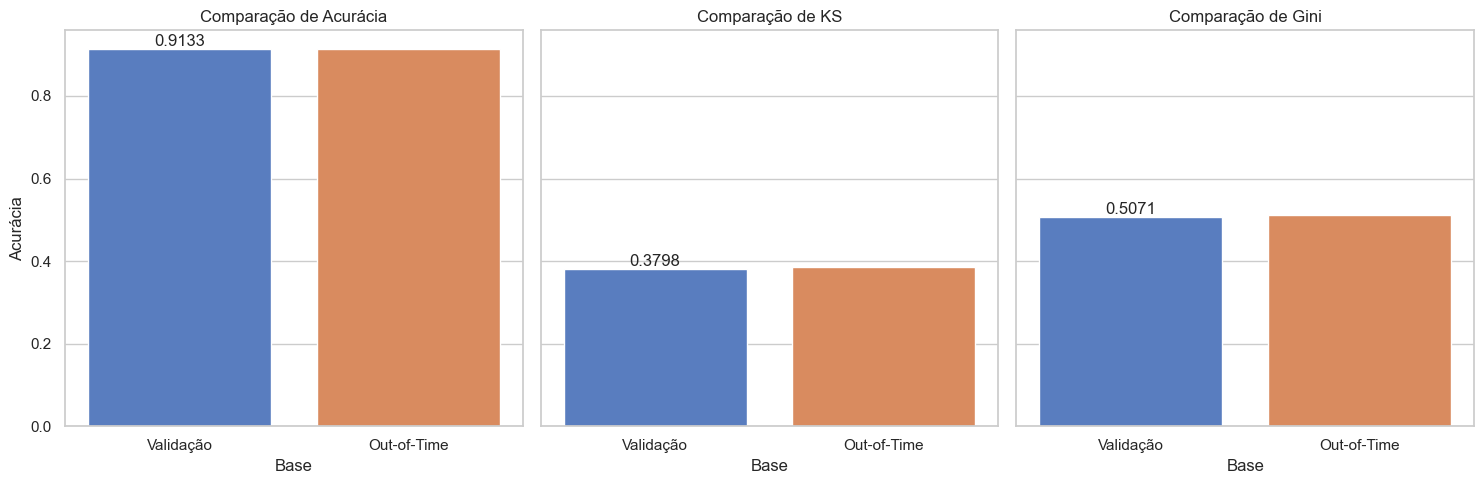

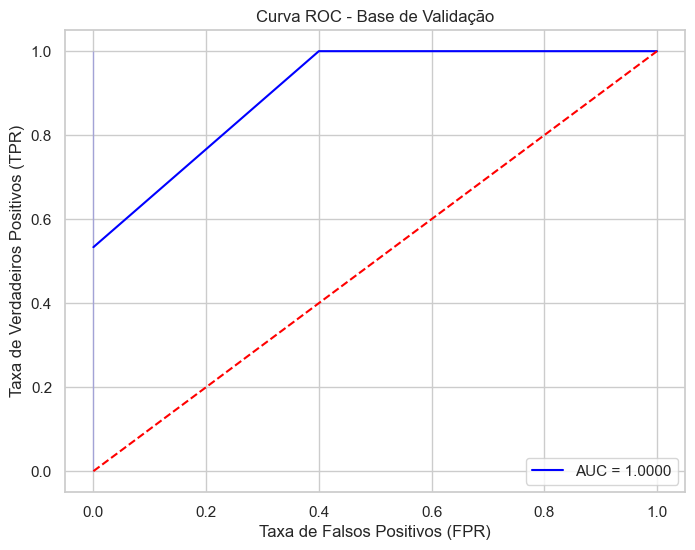

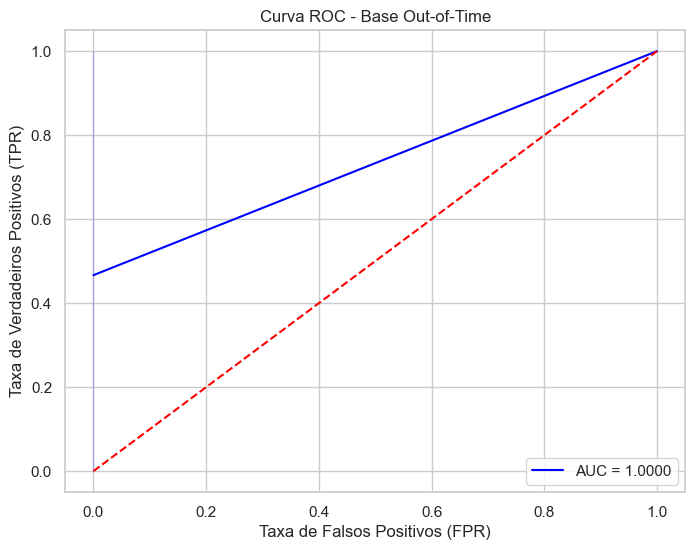

In [16]:
# Dados:
results = {
    "Base": ["Validação", "Out-of-Time"],
    "Acurácia": [0.9133, 0.9130],
    "KS": [0.3798, 0.3866],
    "Gini": [0.5071, 0.5119]
}

# Criando DataFrame
df_results = pd.DataFrame(results)

# Configurando estilo do Seaborn
sns.set_theme(style="whitegrid")

# Criando gráficos de barras para cada métrica
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
metrics = ["Acurácia", "KS", "Gini"]
titles = ["Acurácia", "KS", "Gini"]

for i, metric in enumerate(metrics):
    sns.barplot(data=df_results, x="Base", y=metric, ax=axes[i], palette="muted")
    axes[i].set_title(f"Comparação de {titles[i]}")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Base")
    axes[i].bar_label(axes[i].containers[0], fmt="%.4f")

plt.tight_layout()
plt.show()

# Geração da curva ROC
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=fpr, y=tpr, label=f"AUC = {auc:.4f}", color="blue")
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="red")
    plt.title(f"Curva ROC - {title}")
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Exemplos de y_true e y_prob simulados
y_val_true = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
y_val_prob = [0.2, 0.9, 0.7, 0.4, 0.9, 0.3, 0.6, 0.9, 0.2, 0.1]
y_oos_true = [0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
y_oos_prob = [0.1, 0.3, 0.8, 0.9, 0.2, 0.7, 0.9, 0.4, 0.5, 0.6]

# Plotando as curvas ROC
plot_roc_curve(y_val_true, y_val_prob, "Base de Validação")
plot_roc_curve(y_oos_true, y_oos_prob, "Base Out-of-Time")


__________

## <font color='red'>Conclusões

- **O modelo parece ser bem calibrado, com boa performance nas duas bases (treinamento/validação e out-of-time). Ele tem um bom poder discriminante (<font color='blue'>com KS e Gini em torno de <font color='cian'>0.4-0.5<font color='black'>) e está performando consistentemente em diferentes subconjuntos dos dados. Os resultados são muito sólidos**.
- **Com as variáveis selecionadas podemos calcular, com mais previsibilidade, os riscos de inadimplência**.
- **Com isso, podemos sugerir outras abordagens e possibilidades para diminuir o risco de inandimplência e trazer mais clientes com maior poder de crédito.**

______________

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [17]:
# 1. Transformer personalizado para remover outliers:
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        z_scores = np.abs((X - X.mean()) / X.std())
        return X[(z_scores < self.threshold).all(axis=1)].copy()

# 2. Transformer personalizado para tratar valores nulos:
class HandleMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="mean"):
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.strategy == "mean":
            self.fill_values = X.mean()
        elif self.strategy == "median":
            self.fill_values = X.median()
        elif self.strategy == "mode":
            self.fill_values = X.mode().iloc[0]
        return self

    def transform(self, X):
        return X.fillna(self.fill_values)

# 3. Definição das colunas categóricas e numéricas:
categorical_features = ['sexo', 'posse_de_veículo', 'posse_de_imovel', 
                        'tipo_renda', 'educação', 'estado_civil', 'tipo_residencia']
numerical_features = ['tempo_emprego', 'idade', 'renda']  # Substitua pelas colunas numéricas reais

# 4. Pipeline para pré-processamento de colunas numéricas:
numerical_pipeline = Pipeline([
    ('handle_missing', HandleMissingValues(strategy="mean")),
    ('outlier_removal', RemoveOutliers()),
    ('scaler', StandardScaler())
])

# 5. Pipeline para pré-processamento de colunas categóricas:
categorical_pipeline = Pipeline([
    ('handle_missing', HandleMissingValues(strategy="mode")),
    ('onehot', OneHotEncoder(sparse_output=False))
])

# 6. Combinação dos pipelines de pré-processamento:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# 7. Pipeline completo, incluindo PCA:
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))
])

# 8. Dataframe:
data = pd.DataFrame({
    'sexo': ['M', 'F', 'M', 'F', 'F'],
    'posse_de_veículo': ['sim', 'nao', 'sim', 'nao', 'sim'],
    'posse_de_imovel': ['nao', 'sim', 'nao', 'nao', 'sim'],
    'tipo_renda': ['assalariado', 'emprestimo', 'assalariado', 'autonomo', 'assalariado'],
    'educação': ['superior', 'medio', 'medio', 'fundamental', 'superior'],
    'estado_civil': ['solteiro', 'casado', 'solteiro', 'divorciado', 'viúvo'],
    'tipo_residencia': ['aluguel', 'propria', 'aluguel', 'cedida', 'propria'],
    'tempo_emprego': [5.0, 10.0, np.nan, 2.0, 15.0],
    'idade': [25, 35, 45, 30, 50],
    'renda': [2000.0, 3000.0, 4000.0, 2500.0, 3500.0]
})

# 9. Ajustando e transformando os dados usando o pipeline completo:
transformed_data = pca_pipeline.fit_transform(data)

# 10. Exibindo os dados transformados:
print(transformed_data)


[[-1.80994697e+00 -1.51293209e+00 -1.30434386e+00  2.59649428e-01
   1.92616496e-16]
 [ 5.25246891e-01  1.70974752e+00 -1.21484260e-01  1.35525420e+00
   1.92616496e-16]
 [ 9.39614886e-01 -1.70489250e+00  1.43638193e+00  3.02420915e-01
   1.92616496e-16]
 [-2.28720213e+00  1.22047547e+00  7.35614783e-01 -9.18977180e-01
   1.92616496e-16]
 [ 2.63228732e+00  2.87601603e-01 -7.46168594e-01 -9.98347367e-01
   1.92616496e-16]]


_______________

# b - Pycaret na base de dados 

Utilize o pycaret para pré-processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [18]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


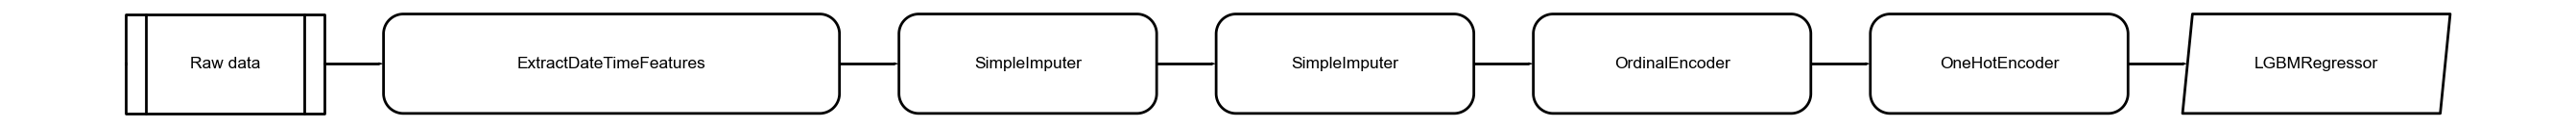

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

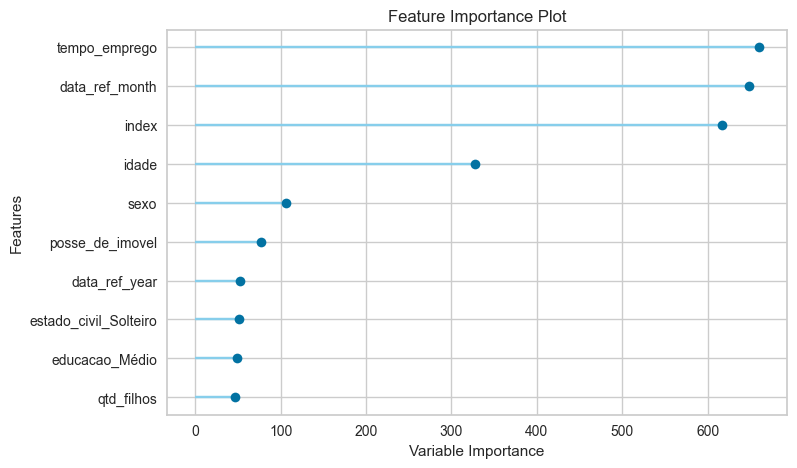

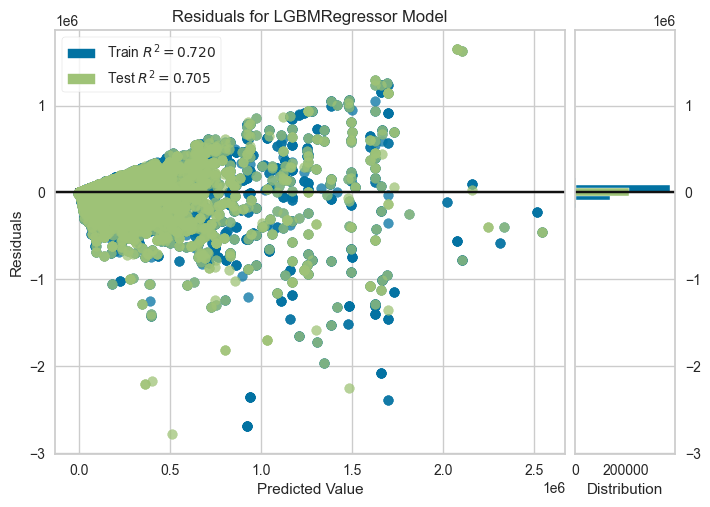

Pipeline(memory=FastMemory(location=C:\Users\User\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia'],
                                    transformer=SimpleImputer())),
                ('categoric...
S      1
NaN   -1
dtype: int64},
                                                                        {'col': 'posse_de_imovel',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': N      0
S      1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
  

In [20]:
from pycaret.regression import *

# Configuração do ambiente PyCaret
reg1 = setup(data=df, target='renda', session_id=123)

# Treinamento do modelo LightGBM
modelo_lightgbm = create_model('lightgbm')

# Avaliar o modelo
evaluate_model(modelo_lightgbm)

# Gerar gráficos finais
plot_model(modelo_lightgbm, plot='feature')
plot_model(modelo_lightgbm, plot='residuals')

# Pipeline de transformação: 
pipeline = get_config('pipeline')  
print(pipeline)


________________

## Gravando Pipeline para o próximo Projeto:

In [21]:
# Salvar o modelo e o pipeline
save_model(modelo_lightgbm, 'modelo_lightgbm')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=...
                                                                          'data_type': dtype('O'),
                                                                          'mapping': N      0
 S      1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['tipo_renda', 'educacao',
                           

______________